# **Лабораторная работа №4 по вычислительной математикe.**

## Работу выполнил: Аль Мажариш Гасем, Б01 - 202а.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Формулировка задачи:

- посчитать 1-ю производную методом 1 и 2 порядка
- посчитать 2-ю производную методом 2 порядка
- сравнить с посчитанной методами мат. анализа производной
- построить графики для проверки порядков методов
- получить оптимальный шаг сетки для выбранного машинного $\varepsilon$


## Теоретическая справка

Изначально имеем два массива: массив значений аргумента X и массив значений функции Y. Соседние значения X отличаются на шаг h.
В самом примитивном случае:

$f'(x) = \frac{f(x + h) - f(x)}{h}$,

где чем меньше значение шага h, тем точнее результат. На практике, удобнее реализовывать вычисления свёрткой:

f'(x) = (f * k), 

где k - свёрточное ядро. В случае первой производной первого порядка k = [0, -1, 1].
Производя свёртку, считается скалярное произведение ядра и подматриц одномерной матрицы функции, на основе чего и получаются значения
производной в разных точках.

Свёртка используется для оптимизации вычислительных процессов, т.к. она уже реализована в numpy.

## Реализация первой производной

In [9]:
# Функция вычисления первой производной методом свёртки
def calc_derivative(func, derivative, kernel, bounds, step):
    '''
        func - ф-ция
        derivative - функция производной (для сравнения)
        kernel - ядро свёртки (для самого простого случая [-1, 1])
        bounds - список с началом и концом отрезка
        step - шаг дискретизации функции
    '''
    kernel = np.array(kernel, dtype=np.float64)

    X = np.arange(bounds[0], bounds[1], step, dtype=np.float64)
    Y = func(X)
    Yd_true = derivative(X)

    kernel /= step

    Yd = np.convolve(Y, kernel[::-1], 'valid')

    # Обрезка крайних значений для корректности результата
    endsize = len(kernel) // 2
    X = X[endsize:-endsize]
    Y = Y[endsize:-endsize]
    Yd_true = Yd_true[endsize:-endsize]

    return X, Y, Yd, Yd_true

# Задание метрики
def metric(Yd, Yd_true): 
    err = np.abs(Yd_true - Yd)
    return np.max(err)

# Сравнение численного и аналитического результата дифференциирования
def calc_errors(func, derivative, kernel, bounds, step_powers):
    N = np.arange(step_powers[0], step_powers[1] + 1, 1)
    S = np.empty_like(N, dtype=np.float64)
    E = np.empty_like(S)

    for i in range(len(N)):
        S[i] = 2. / 2**N[i]
        _, Y, Yd, Yd_true = calc_derivative(func, derivative, kernel, bounds, S[i])

        E[i] = metric(Yd_true, Yd)

    return np.array(N), np.array(S), np.array(E)

def get_results(func, derivative, bounds, step_powers, labelled_kernels):
    results = []

    for kernel, label in labelled_kernels:
        result = calc_errors(func, derivative, kernel, bounds, step_powers)
        results.append((*result, label))

    return results

## Реализация второй производной

In [8]:
# Функция вычисления второй производной методом свёртки
def calc_derivative_sec(func, derivative, kernel, bounds, step):
    '''
        func - ф-ция
        derivative - функция 2-й производной (для сравнения)
        kernel - ядро свёртки (например, [1, -2, 1])
        bounds - список с началом и концом отрезка
        step - шаг дискретизации функции
    '''
    kernel = np.array(kernel, dtype=np.float64)

    # Создаем сетку X и вычисляем значения функции и её истинной производной
    X = np.arange(bounds[0], bounds[1], step, dtype=np.float64)
    Y = func(X)
    Yd_true = derivative(X)

    # Масштабируем ядро для второй производной
    kernel /= (step**2)

    # Выполняем свёртку
    Yd = np.convolve(Y, kernel[::-1], 'valid')

    # Обрезка крайних значений для корректности результата
    endsize = len(kernel) // 2
    X = X[endsize:-endsize]
    Y = Y[endsize:-endsize]
    Yd_true = Yd_true[endsize:-endsize]

    return X, Y, Yd, Yd_true

# Задание метрики
def metric(Yd, Yd_true): 
    err = np.abs(Yd_true - Yd)
    return np.max(err)

# Сравнение численного и аналитического результата дифференцирования
def calc_errors_sec(func, derivative, kernel, bounds, step_powers):
    N = np.arange(step_powers[0], step_powers[1] + 1, 1)
    S = np.empty_like(N, dtype=np.float64)
    E = np.empty_like(S)

    for i in range(len(N)):
        S[i] = 2. / 2**N[i]
        _, Y, Yd, Yd_true = calc_derivative_sec(func, derivative, kernel, bounds, S[i])

        E[i] = metric(Yd_true, Yd)

    return np.array(N), np.array(S), np.array(E)

def get_results_sec(func, derivative, bounds, step_powers, labelled_kernels):
    results = []

    for kernel, label in labelled_kernels:
        result = calc_errors_sec(func, derivative, kernel, bounds, step_powers)
        results.append((*result, label))

    return results


## Отрисовка результатов

In [40]:
def plot_derivative(X, Yd, Yd_true, title):
    plt.plot(X, Yd_true, 'k--', label="$True$")
    plt.plot(X, Yd, 'r-', label="$Calculated$")

    plt.title(title)

    plt.legend()
    plt.grid()
    plt.show()

def plot_results(results, title):
    for result in results:
        S = result[1]
        E = result[2]
        label = result[3]

        a, b = np.polyfit(np.log(S[5:14]), np.log(E[5:14]), 1)
        plt.scatter(np.log(S), np.log(E), label=label)
        plt.plot(np.log(S[5:14]), a * np.log(S[5:14]) + b, label=f"{a:.3}x + {b:.3}")

    plt.title(title)
    plt.xlabel("$ln(h)$")
    plt.ylabel("$ln(\Delta)$")

    plt.grid()
    plt.legend()
    plt.show()

## Проверка

$f(x) = sin(x^2)$

$f'(x) = 2xcos(x^2)$

$f''(x) = 2cos(x^2) - 4x^2sin(x^2)$

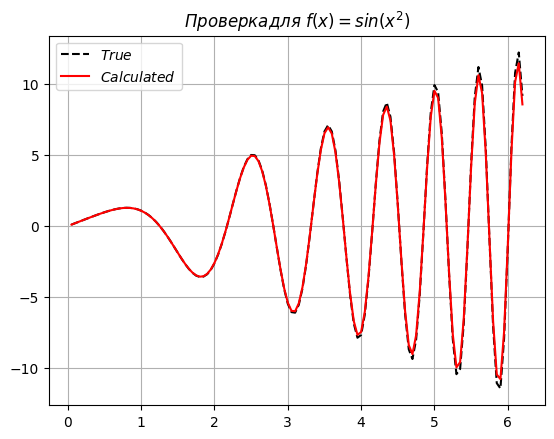

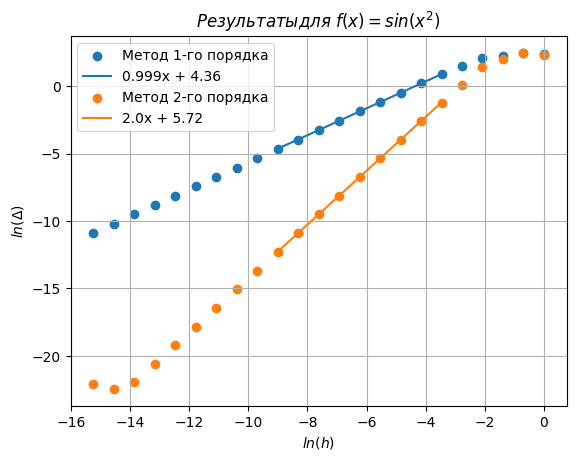

In [41]:
# Первая производная
function = lambda X: np.sin(X * X)
derivative = lambda X: 2 * X * np.cos(X * X)

kernels = [
            ([0, -1, 1], "Метод 1-го порядка"),
            ([-0.5, 0, 0.5], "Метод 2-го порядка")
          ]

bounds = (0, 2*np.pi)
step_powers = (1, 23)
step = 0.05

X, Y, Yd, Yd_true = calc_derivative(function, derivative, [-0.5, 0, 0.5], bounds, step)
plot_derivative(X, Yd, Yd_true, "$Проверка для~ f(x)=sin(x^2)$")

results = get_results(function, derivative, bounds, step_powers, kernels)
plot_results(results, "$Результаты для~ f(x)=sin(x^2)$")

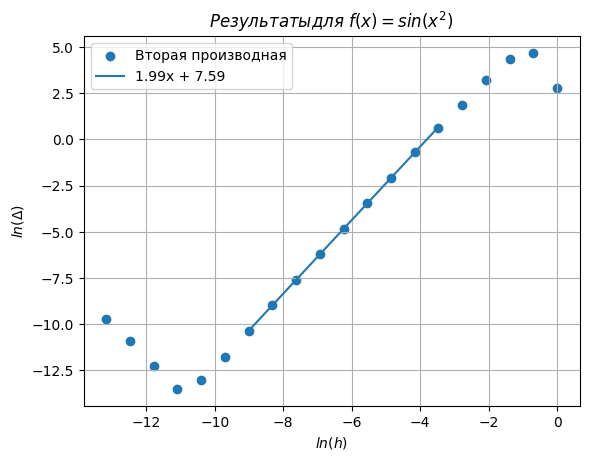

In [42]:
# Вторая производная
function = lambda X: np.sin(X * X)
derivative_sec = lambda X: 2 * np.cos(X * X) - 4 * X * X * np.sin(X * X)

kernels_sec = [([1, -2, 1], "Вторая производная")]

bounds = (0, 2 * np.pi)
step_powers_sec = (1, 20)

results = get_results_sec(function, derivative_sec, bounds, step_powers_sec, kernels_sec)
plot_results(results, "$Результаты для~ f(x)=sin(x^2)$")

## Оценка оптимального шага сетки

Как видим из графиков, оптимальный шаг сетки для первой и для второй производной:

$h_1 = 2^{-15}$

$h_2 = 2^{-9}$

Эти значения получены исходя из точек излома графиков, где из-за конечности машинного $\epsilon$ метод перестаёт сходиться.